# Compute (YOLO) detection accuracy
First, we'll import the ground truth video and blender tracked file

In [1]:
import numpy as np
import cv2
import csv
import os
import math
import time
import random
import sys
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from operator import itemgetter

# now for the file management fucntions
from Antrax_base import import_tracks, display_video, get_exact_frame, extractPatches, display_patches, sortByDistance

ground_truth_tracks = "C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/benchmark/sub_colony_tracking/NAT/export_base_NAT/"
predicted_tracks = "C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/benchmark/sub_colony_tracking/BLENDER_TRACKING_OUTPUT/base_synth/"
video = "C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/benchmark/sub_colony_tracking/pre_processed_video/rec_climate_chamber_sub_colony_base_10000_frames_CLEAN.mp4"

# enter the number of annotated frames:
tracked_frames = 1000

# now we can load the captured video file and display it
cap = cv2.VideoCapture(video)

# check the number of frames of the imported video file
numFramesMax = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("The imported clip:", video, "has a total of",numFramesMax ,"frames.\n")

# now let's load all tracks listed in the export_paths
tracks = import_tracks(predicted_tracks, numFramesMax, export=False)

# The following function is used to display the tracks you imported.
# You can press "q" while hovering over the displayed video to exit.
print("\nDisplaying tracks loaded from:", predicted_tracks)
display_video(cap, tracks, show=(0, tracked_frames), scale=0.3)# scale=1, output_file="C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/benchmark/sub_colony_tracking/RESULTS/" + video[:-4].split("/")[-1] +'_annotations.avi')

ground_truth = import_tracks(ground_truth_tracks, numFramesMax, export=False)

The imported clip: C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/benchmark/sub_colony_tracking/pre_processed_video/rec_climate_chamber_sub_colony_base_10000_frames_CLEAN.mp4 has a total of 2000 frames.

importing tracks...
imported rec_climate_chamber_sub_colony_base_10000_frames_CLEAN_track_0.csv  with 1000 points.
imported rec_climate_chamber_sub_colony_base_10000_frames_CLEAN_track_1.csv  with 1000 points.
imported rec_climate_chamber_sub_colony_base_10000_frames_CLEAN_track_10.csv  with 1000 points.
imported rec_climate_chamber_sub_colony_base_10000_frames_CLEAN_track_102.csv  with 191 points.
imported rec_climate_chamber_sub_colony_base_10000_frames_CLEAN_track_103.csv  with 918 points.
imported rec_climate_chamber_sub_colony_base_10000_frames_CLEAN_track_104.csv  with 178 points.
imported rec_climate_chamber_sub_colony_base_10000_frames_CLEAN_track_107.csv  with 99 points.
imported rec_climate_chamber_sub_colony_base_10000_frames_CLEAN_track_109.csv  with 25 points.


Now, to **compare the processed tracks** to the **ground truth** of each frame, we need to compare every detection to every ground truth instance. This may be computationally expensive, but it ensures all detections are considered. The process can be easiliy multi threaded if desired as each frame is compared independently of the others

In [2]:
from scipy.spatial import distance

max_detection_distance_px = 25 # only detections closer than X px away from the centre of a ground truth track are considered correct detections

total_gt_detections = 0 # number of total detections in the ground truth dataset
total_missed_detections = 0 # number of missed detections which are present in the groud truth dataset
total_false_positives = 0 # number of incorrect detections that do not match any groud thruth tracks
all_frame_detection_deviations = [] # list of mean pixel deviations for correct detections
ID_List = []
total_ID_switches = 0

def compare_points(gt,detection, max_dist=25):
    match = False
    px_distance = distance.euclidean(gt, detection)
    if px_distance <= max_dist:
        match = True
    return match, px_distance

def compare_frame(frame_gt, frame_detections, max_dist=50, ID_List=[]):
    gt_detections = int((len(frame_gt) - 1) / 2)
    gt_not_present = gt_detections - int((np.count_nonzero(frame_gt!=0) - 1) / 2)
    matches_gt = np.ones(gt_detections)
    
    p_detections = int((len(frame_detections) - 1) / 2)
    p_not_present = p_detections - int((np.count_nonzero(frame_detections!=0) - 1) / 2)
    matches_det = np.ones(p_detections)
    
    detection_distances = []
    ID_switches = 0 # add +1 for every assignment error (includes ID switches and fragmented tracks)
    # now strip all empty entries from the ground truth and predictions
    
    # if the ID_List is empty create it now. Each GT track has a unique ID (y) to which a predicted track ID (p) is assigned
    if len(ID_List) == 0:
        for ID in range(gt_detections):
            ID_List.append(-1)  # -1 means that no predicted track ID (p) has been assigned yet
            
        #print(ID_List)
            
    ID_List_updated = ID_List.copy()
    # keep track of "initial assignments", as they are not considered switches
    initial_assignments = 0
    
    for i in range(len(matches_gt)):
        min_dist = 9999
        for j in range(len(matches_det)):
            # only compare valid tracks
            if any(frame_gt[(i*2)+1:(i*2)+3] != 0) and any(frame_detections[(j*2)+1:(j*2)+3] != 0):
                match, px_dist = compare_points(gt=frame_gt[(i*2)+1:(i*2)+3], detection=frame_detections[(j*2)+1:(j*2)+3], max_dist=max_dist)
                if match:
                    matches_gt[i] = 0
                    matches_det[j] = 0
                    if px_dist < min_dist:
                        min_dist = px_dist
                        if ID_List_updated[i] == -1:
                            initial_assignments += 1
                        ID_List_updated[i] = j
        if min_dist < 9999:
            detection_distances.append(min_dist)
            
    missed_detections = int(np.sum(matches_gt)) - gt_not_present
    false_positives = int(np.sum(matches_det)) - p_not_present
    gt_present_detections = gt_detections - gt_not_present
    
    #print("out of", len(matches_gt), "unmatched ground truth",np.count_nonzero(matches_gt!=0))
    #print("out of", len(matches_det), "unmatched predictions ",np.count_nonzero(matches_det!=0))
    
    ID_switches = sum(1 for i, j in zip(ID_List_updated, ID_List) if i != j) - initial_assignments

    if len(detection_distances) == 0:
        mean_detection_distance = 0
    else:
        mean_detection_distance = np.mean(np.array(detection_distances))
    
    return gt_present_detections, missed_detections, false_positives, mean_detection_distance, ID_switches, ID_List_updated

for f in range(tracked_frames):
    gt_detections, missed_detections, false_positives, mean_detection_distance, ID_switches, ID_List = compare_frame(frame_gt=ground_truth[f], frame_detections=tracks[f], max_dist=max_detection_distance_px, ID_List=ID_List)
    total_gt_detections += gt_detections
    total_missed_detections += missed_detections
    total_false_positives += false_positives
    total_ID_switches += ID_switches
    all_frame_detection_deviations.append(mean_detection_distance)
    
mean_px_error = np.mean(all_frame_detection_deviations)
detection_accuracy = ((total_gt_detections - total_missed_detections - total_false_positives) / total_gt_detections) * 100
MOTA = 1 - (total_missed_detections + total_false_positives + total_ID_switches) / total_gt_detections

print("DETECTION STATS:")
print("Total ground truth detections: ",total_gt_detections)
print("Total missed detections:       ",total_missed_detections)
print("Total false  positives:        ",total_false_positives)
print("Detection accuracy (GT - FP - MD) / GT):", np.round(detection_accuracy, 1),"%")
print("Mean pixel error:", np.round(mean_px_error,3))

print("\nTRACKING STATS:")
print("Total number of ID switches:   ",total_ID_switches)
print("MOTA:", np.round(MOTA,3))
    

DETECTION STATS:
Total ground truth detections:  62177
Total missed detections:        4193
Total false  positives:         636
Detection accuracy (GT - FP - MD) / GT): 92.2 %
Mean pixel error: 5.087

TRACKING STATS:
Total number of ID switches:    22
MOTA: 0.922


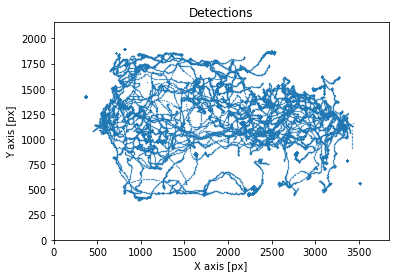

In [3]:
# combine all detections into a single 2D array to produce a simple scatter plot
all_xy = []
for frame in tracks:
    num_gt_detections = int((np.count_nonzero(frame!=0) - 1) / 2)
    for j in range(num_gt_detections):
        all_xy.append(frame[(j*2)+1:(j*2)+3])
        
cap_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    
all_xy = np.array(all_xy)
all_xy = np.reshape(all_xy, (-1,2)) # ensures the format can be read by matplotlib

plt.scatter(all_xy[:,0],all_xy[:,1],s=0.1)
plt.title("Detections")    
plt.xlabel("X axis [px]")   
plt.ylabel("Y axis [px]")
plt.xlim(0,cap_width)
plt.ylim(0,cap_height)

plt.show()